<a href="https://colab.research.google.com/github/rubythalib33/Sekolah-AI-Indonesia/blob/main/Course%201.%20Pytorch%2BLightning%20Coureses%20Level%201/1_10_Variational_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.10 Variational AutoEncoder

In [1]:
!pip install pytorch_lightning

     |████████████████████████████████| 527 kB 5.6 MB/s 
     |████████████████████████████████| 397 kB 33.7 MB/s 
     |████████████████████████████████| 952 kB 9.7 MB/s 
     |████████████████████████████████| 596 kB 37.9 MB/s 
     |████████████████████████████████| 829 kB 38.1 MB/s 
     |████████████████████████████████| 134 kB 32.4 MB/s 
     |████████████████████████████████| 1.1 MB 32.3 MB/s 
     |████████████████████████████████| 144 kB 30.6 MB/s 
     |████████████████████████████████| 271 kB 45.4 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=ddc51c3884301f60ddba726362a203560d069221011248c98df5a0cc1b15b091
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfull

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import torchvision.transforms.functional as TF

import pytorch_lightning as pl
from IPython import display

In [3]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
batch_size = 16

#create dataloaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [5]:
EPOCHS = 10
latent_dim = 2
num_examples_to_generate = 16

random_vector_for_generation = torch.randn((num_examples_to_generate, latent_dim))

In [6]:
class CVAE(pl.LightningModule):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()

    self.test_sample = next(iter(test_dataloader))
    self.epoch = 0

    self.latent_dim = latent_dim
    self.encoder = nn.Sequential(
        nn.Conv2d(1,32, 3, 2),
        nn.ReLU(inplace=True),
        nn.Conv2d(32,64, 3, 2),
        nn.ReLU(inplace=True),
        nn.Flatten(),
        nn.Linear(6*6*64, latent_dim+latent_dim)
    )

    self.bottleneck = nn.Linear(latent_dim, 7*7*32)

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(32, 64, 3, 2),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(64, 32, 3, 2),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(32,1, 3, 1)
    )

  def encode(self,x):
    mean, logvar = torch.split(self.encoder(x), 2, dim=1)
    return mean, logvar
  
  def reparameterize(self, mean, logvar):
    eps = torch.randn(mean.shape).cuda()
    return eps * torch.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = torch.sigmoid(logits)
      return probs
    return logits
  
  def forward(self, z=None):
    if z is None:
      z = torch.randn(shape=(100, self.latent_dim))
    
    z = self.bottleneck(z)

    B, T = z.size()
    z = torch.reshape(z, (B, 32, 7, 7))

    z = self.decode(z,apply_sigmoid=True)

    z = TF.resize(z, size=(28,28))
    return z
  
  def log_normal_pdf(self, sample, mean, logvar, rdim=1):
    log2pi = np.log(2. * torch.pi)
    exp = np.exp(-logvar) if isinstance(logvar, float) else torch.exp(-logvar)
    return torch.sum(
        -.5 * ((sample-mean) ** 2. * exp + logvar + log2pi)
    )
  
  def compute_loss(self,x):
    mean, logvar = self.encode(x)
    z = self.reparameterize(mean, logvar)
    x_logit = self.bottleneck(z)
    B, T = x_logit.size()
    x_logit = torch.reshape(x_logit, (B, 32, 7, 7))
    x_logit = self.decode(x_logit)

    x_logit = TF.resize(x_logit, size=x.shape[2:])

    cross_ent = torch.nn.functional.binary_cross_entropy_with_logits(x_logit, x, reduction='none')
    logpx_z = -torch.sum(cross_ent, dim=[1,2,3])
    logpz = self.log_normal_pdf(z, 0., 0.)
    logqz_x = self.log_normal_pdf(z, mean, logvar)

    return -torch.mean(logpx_z+logpz - logqz_x)
  
  def training_step(self, batch, batch_bn):
    X, _ = batch

    loss = self.compute_loss(X)

    return loss
  
  def validation_step(self, batch, batch_bn):
    X, _ = batch

    loss = self.compute_loss(X)

    return loss
  
  def validation_epoch_end(self, validation_step_outputs):
    display.clear_output(wait=False)
    self.generate_and_save_images(self.epoch, self.test_sample)
    self.epoch+=1
  
  def generate_and_save_images(self, epoch, test_sample):
    mean, logvar = self.encode(test_sample[0].cuda())
    z = self.reparameterize(mean, logvar)
    preds = self(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(preds.shape[0]):
      plt.subplot(4, 4, i + 1)
      plt.imshow(preds[i, 0, :, :].cpu(), cmap='gray')
      plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
  
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-4)


In [7]:
model = CVAE(latent_dim)

In [8]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=10,
    progress_bar_refresh_rate=10,
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


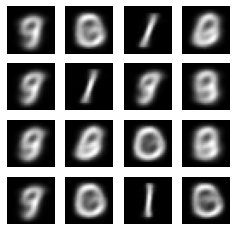

In [9]:
# Train the model ⚡
trainer.fit(model, train_dataloader, test_dataloader)